Reading the ARFF file.

In [188]:
from scipy.io.arff import loadarff
import pandas as pd, numpy as np

data = loadarff('column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')


Separate input from output data and normalize the features using sklearn's minmax scaler.

In [189]:
from sklearn.preprocessing import MinMaxScaler

features = df.drop('class', axis=1)
target = df['class']

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

**Exercise 1**

Define purity_score and create 2 arrays, 1 to store purity values and 1 to store silhouette values. In a for loop, create kmeans algorithms with k={2, 3, 4, 5}, train them and calculate purity and silhouette values. At the end, store them in the respective array. 

In [190]:
from sklearn import metrics, cluster

def purity_score(y_true, y_pred):
    # compute contingency/confusion matrix
    confusion_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix) 

silhouettes = []
purities = []

for k in range(2, 6):
    kmeans_algo = cluster.KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_algo.fit(features_scaled)
    target_pred = kmeans_model.labels_
    purity = purity_score(target, target_pred)
    silhouette = metrics.silhouette_score(features_scaled, target_pred)
    silhouettes.append(silhouette)
    purities.append(purity)
    
    print("Purity score for k = " , str(k) , " is " , purity)
    print("Silhouette score for k = " , str(k) , " is " , silhouette)

/home/rofarate/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rofarate/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rofarate/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Purity score for k =  2  is  0.632258064516129
Silhouette score for k =  2  is  0.36044124340441114
Purity score for k =  3  is  0.667741935483871
Silhouette score for k =  3  is  0.29579055730002257
Purity score for k =  4  is  0.6612903225806451
Silhouette score for k =  4  is  0.27442402122340176
Purity score for k =  5  is  0.6774193548387096
Silhouette score for k =  5  is  0.23823928397844843


/home/rofarate/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Plot the silhouette and purity.

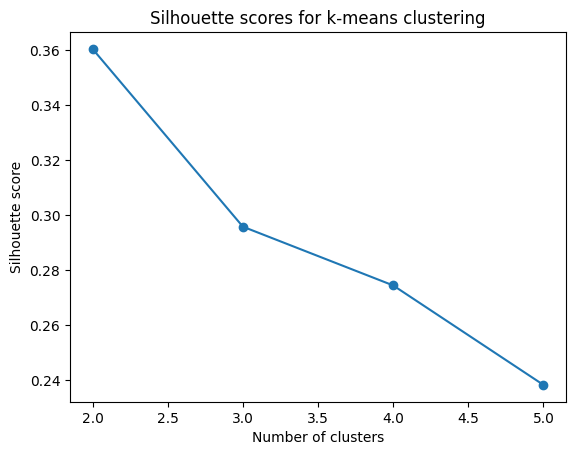

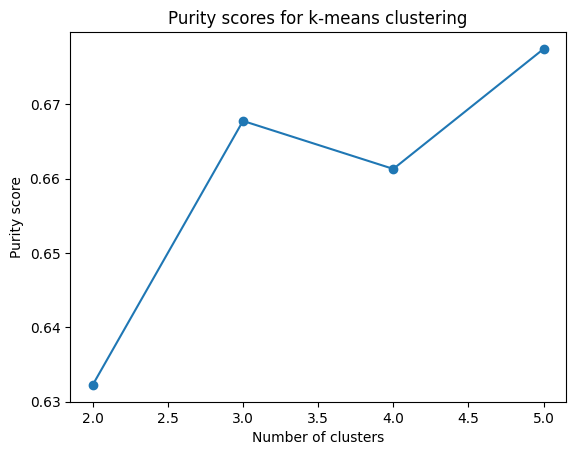

In [191]:
import matplotlib.pyplot as plt

#Plot Silhouette
plt.plot([2,3,4,5], silhouettes, 'o-')
plt.title('Silhouette scores for k-means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.savefig('ex1_silhouette.png')
plt.show()

#Plot Purity
plt.plot([2,3,4,5], purities, 'o-')
plt.title('Purity scores for k-means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Purity score')
plt.savefig('ex1_purity.png')
plt.show()

**Exercise 2**

**i)**

Create a PCA object, fit the PCA model to the scaled features and transform the original data into a new dataset (X_pca) with only two dimensions. 

In [192]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(features_scaled)
X_pca = pca.transform(features_scaled)

print("Components (eigenvectors):\n",pca.components_)
print("Explained variance (eigenvalues) =",pca.explained_variance_)
print("Explained variance (ratio) =",pca.explained_variance_ratio_)

Components (eigenvectors):
 [[ 0.59162062  0.46703944  0.51508476  0.32568886 -0.11582398  0.21692963]
 [ 0.10003707 -0.67037276  0.08004745  0.44330299 -0.58107384  0.00458291]]
Explained variance (eigenvalues) = [0.07345445 0.02739887]
Explained variance (ratio) = [0.56181445 0.20955953]


**ii)**

Extract the eigenvectors of the first and second principal components. These vectors represent the directions of maximum variance in the new feature space. Calculate the importance of each feature in the new feature space. This importance is determined by taking the Euclidean norm of the coefficients of the feature in the eigenvectors. 

In [193]:
import math

xvector = pca.components_[0] * max(X_pca[:,0])
yvector = pca.components_[1] * max(X_pca[:,1])

columns = features.columns
impt_features1 = {columns[i] : math.sqrt(xvector[i]**2) for i in range(len(columns))}
sorted_features1 = sorted(zip(impt_features1.values(),impt_features1.keys()),reverse=True)
print('Features sorted by importance for the first component: \n')
for i in range(len(sorted_features1)):
    print(f'{sorted_features1[i][1]} : {sorted_features1[i][0]: .5f}')

impt_features2 = {columns[i] : math.sqrt(yvector[i]**2) for i in range(len(columns))}
sorted_features2 = sorted(zip(impt_features2.values(),impt_features2.keys()),reverse=True)
print('\nFeatures sorted by importance for the second component: \n')
for i in range(len(sorted_features2)):
    print(f'{sorted_features2[i][1]} : {sorted_features2[i][0]: .5f}')

impt_features = {columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(len(columns))}
sorted_features = sorted(zip(impt_features.values(),impt_features.keys()),reverse=True)
print('\nFeatures sorted by importance: \n')
for i in range(len(sorted_features)):
    print(f'{sorted_features[i][1]} : {sorted_features[i][0]: .5f}')

Features sorted by importance for the first component: 

pelvic_incidence :  0.44394
lumbar_lordosis_angle :  0.38651
pelvic_tilt :  0.35046
sacral_slope :  0.24439
degree_spondylolisthesis :  0.16278
pelvic_radius :  0.08691

Features sorted by importance for the second component: 

pelvic_tilt :  0.37797
pelvic_radius :  0.32762
sacral_slope :  0.24994
pelvic_incidence :  0.05640
lumbar_lordosis_angle :  0.04513
degree_spondylolisthesis :  0.00258

Features sorted by importance: 

pelvic_tilt :  0.51544
pelvic_incidence :  0.44751
lumbar_lordosis_angle :  0.38913
sacral_slope :  0.34957
pelvic_radius :  0.33895
degree_spondylolisthesis :  0.16280


**Exercise 3**

**i)**

Visualize side-by-side the data using the ground diagnoses.

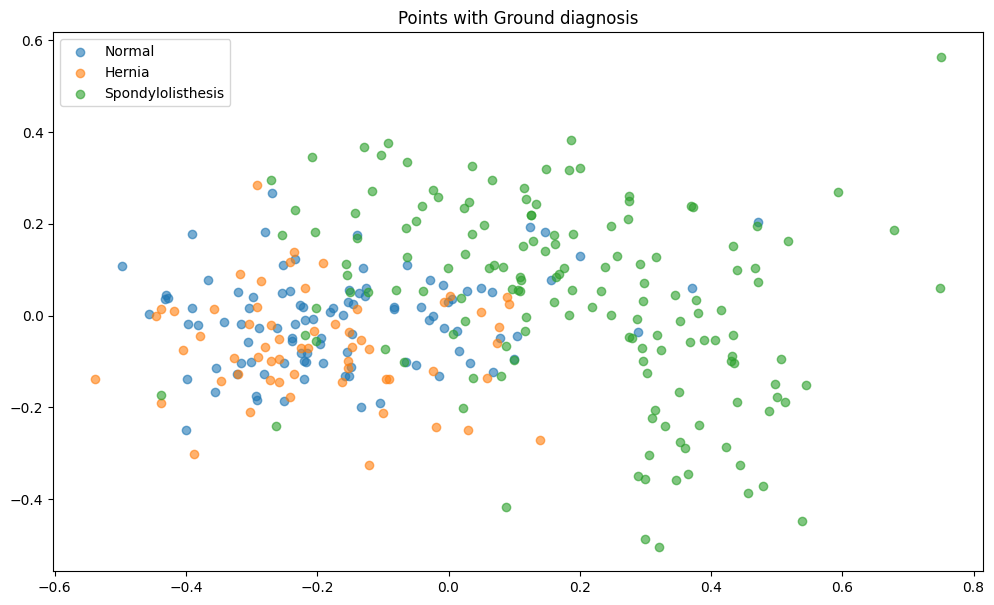

In [194]:
plt.figure(figsize=(12,7))
plt.scatter(X_pca[target=='Normal', 0], X_pca[target=='Normal', 1], alpha=0.6, label='Normal')
plt.scatter(X_pca[target=='Hernia', 0], X_pca[target=='Hernia', 1], alpha=0.6, label='Hernia')
plt.scatter(X_pca[target=='Spondylolisthesis', 0], X_pca[target=='Spondylolisthesis', 1], alpha=0.6, label='Spondylolisthesis')

plt.legend()
plt.title('Points with Ground diagnosis')
plt.savefig('ex3_ground_diagnosis.png')
plt.show()

**ii)**

Visualize side-by-side the data using the previously learned k = 3 clustering solution.

/home/rofarate/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


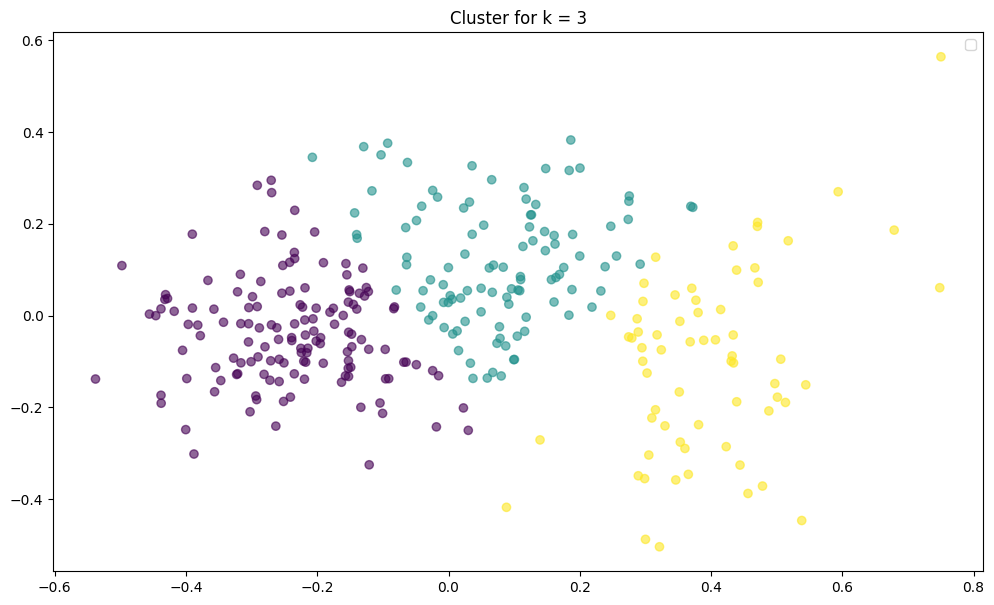

In [195]:
kmeans_algo = cluster.KMeans(n_clusters=3, random_state=0)
kmeans_model = kmeans_algo.fit(features_scaled)
target_pred = kmeans_model.labels_

plt.figure(figsize=(12, 7))
plt.scatter(X_pca[:,0], X_pca[:,1], c=target_pred, alpha=0.6)

plt.legend()
plt.title('Cluster for k = 3')
plt.savefig('ex3_cluster.png')
plt.show()

**Extra/Optional Plot**

Combine the cluster labels with the original class labels into a DataFrame. Calculate mode class for each cluster and create the scatter plot.

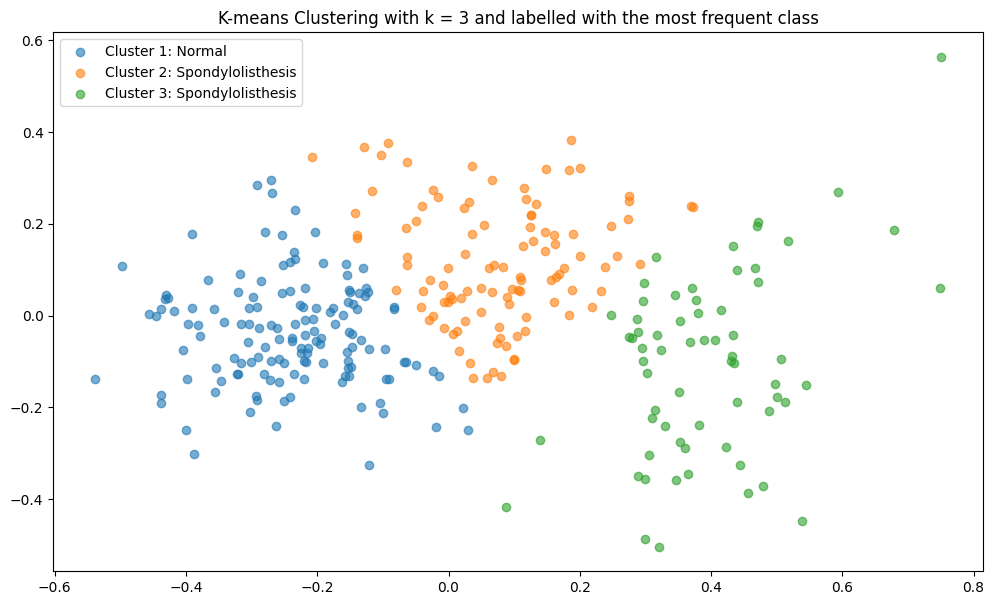

In [196]:
cluster_mapping = pd.DataFrame({'Cluster': target_pred, 'Class': target})

# Calculate the mode class for each cluster
cluster_mode = cluster_mapping.groupby('Cluster')['Class'].agg(lambda x: x.mode().iat[0])

plt.figure(figsize=(12, 7))
for cluster in set(target_pred):
    data = X_pca[target_pred == cluster]
    plt.scatter(data[:, 0], data[:, 1], label=f'Cluster {cluster}', alpha=0.6)

plt.title('K-means Clustering with k = 3 and labelled with the most frequent class') 

# Create a legend using the calculated mode class for each cluster
legend_labels = [f'Cluster {cluster+1}: {mode_class}' for cluster, mode_class in cluster_mode.items()]
plt.legend(legend_labels)

# Show the plot
plt.show()

**Exercise 4**

Based on the results obtained in the previous questions, we conclude that clustering can be used for diagnostics, identifying groups of patients with similar characteristics, or determining the most suitable type of treatment based on the different characteristics among individuals in the population affected by a disease. Through these subgroups of individuals with similar characteristics, it is possible to identify different subtypes of the disease.

This technique is also used to create risk profiles based on population characteristics. This can be employed to implement specific risk mitigation programs.

A deeper analysis of the data within each cluster can help professionals gain a better understanding of the nature of the problem, different ways to diagnose it, and subsequently treat it.

However, the use of clustering requires careful consideration since it's necessary to balance silhouette and purity values (depending on the information we aim to extract from the data), and clusters don't always exclusively represent individuals of the same class. As observed in the last chart of the previous question, two clusters are identified with the same class, so in a more advanced data processing stage, they could likely be merged into one. The previous plots revealed the algorithm's difficulty in distinguishing between populations of people with Hernia and Normal classes.